In [192]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generation/")

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.stats
#plt.style.use("../project_style.mplstyle")
from tqdm import tqdm

import analysis_tools
import stats

In [193]:
sequence = ["walled_square"]*10

In [194]:
path = f"../VPC_l1_10_l2_1"
model, params = analysis_tools.load_model(path, device = "cpu") # model of interest

timesteps = 20000 # timesteps per sequence

Text(0, 0.5, 'Euclidean Error')

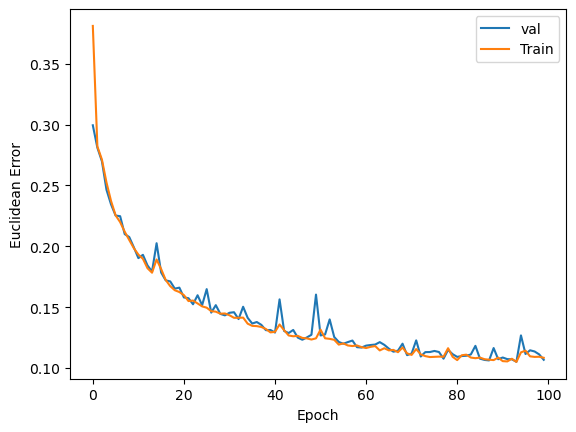

In [195]:
training_losses = np.load(f"{path}/losses.npz")
val_euclid = training_losses["val_euclid"]
train_euclid = training_losses["train_euclid"]

plt.plot(val_euclid, label = "val")
plt.plot(train_euclid, label = "Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Euclidean Error")

In [196]:
x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"]) # create dataset

In [197]:
print(x[0].shape, x[1].shape, r.shape)

torch.Size([10, 20000, 8]) torch.Size([10, 20000, 2]) (10, 20000, 2)


In [198]:
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
gs, ps, centers, preds, metrics = model.inference(dataset)

In [199]:
pred_error = np.linalg.norm(preds - r, axis = -1)

mean_errors = np.mean(pred_error, axis = 1)[:,None]*np.ones((1,r.shape[1]))

In [200]:
temporal_error = np.mean(pred_error, axis = 0)
mean_error = np.mean(pred_error)
print("Mean error", mean_error)

Mean error 0.08928526


In [201]:
n =  200
kdes = np.zeros((n, len(temporal_error)))
ylim = 1 # 
eval_errs = np.linspace(0, ylim, n)

for i in range(pred_error.shape[1]):
    kernel = scipy.stats.gaussian_kde(pred_error[:,i])
    kdes[:, i] = kernel(eval_errs) 

vmin = 0
vmax = np.amax(kdes)

Text(0, 0.5, 'Euclidean Error')

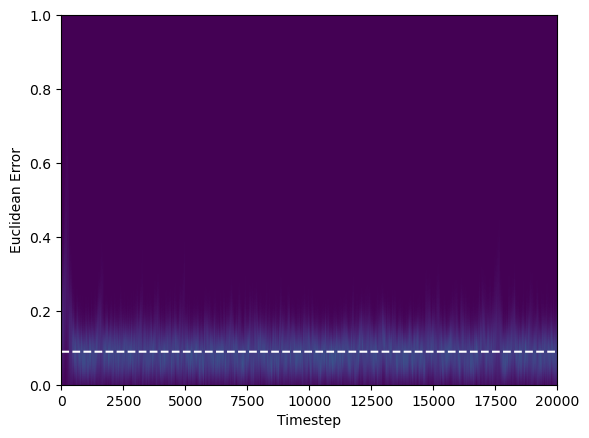

In [202]:
#plt.plot(temporal_error, "k")
plt.plot(np.ones(len(temporal_error))*np.mean(pred_error), "w--")
plt.axis([0, timesteps, 0, ylim])
plt.imshow(kdes, origin = "lower", aspect= "auto", extent = [0, timesteps, 0, ylim], vmin = vmin, vmax = vmax)
#plt.axis("off")
plt.xlabel("Timestep")
plt.ylabel("Euclidean Error")

In [203]:
pc_samples = np.reshape(ps, (-1, ps.shape[-1]))
r_samples = np.reshape(r, (-1, r.shape[-1]))
gc_samples =  np.reshape(gs, (-1, gs.shape[-1]))

bins = [32, 32]

p_ratemaps = stats.population_vector_ratemaps(pc_samples[None], r_samples[None], bins, smooth = False)
g_ratemaps = stats.population_vector_ratemaps(gc_samples[None], r_samples[None], bins, smooth = False)


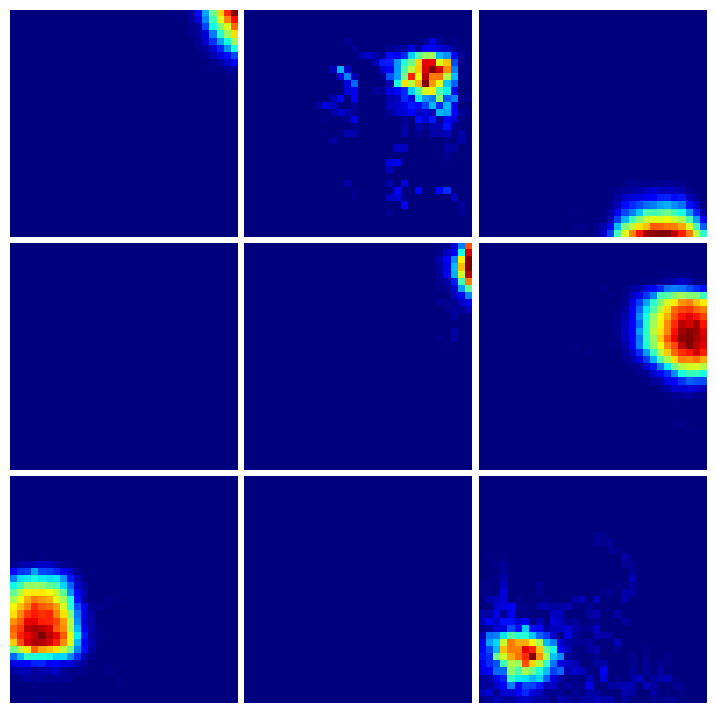

In [204]:
analysis_tools.plot_ensemble(p_ratemaps[0], 3);
plt.subplots_adjust(wspace = 0.025, hspace = 0.025)

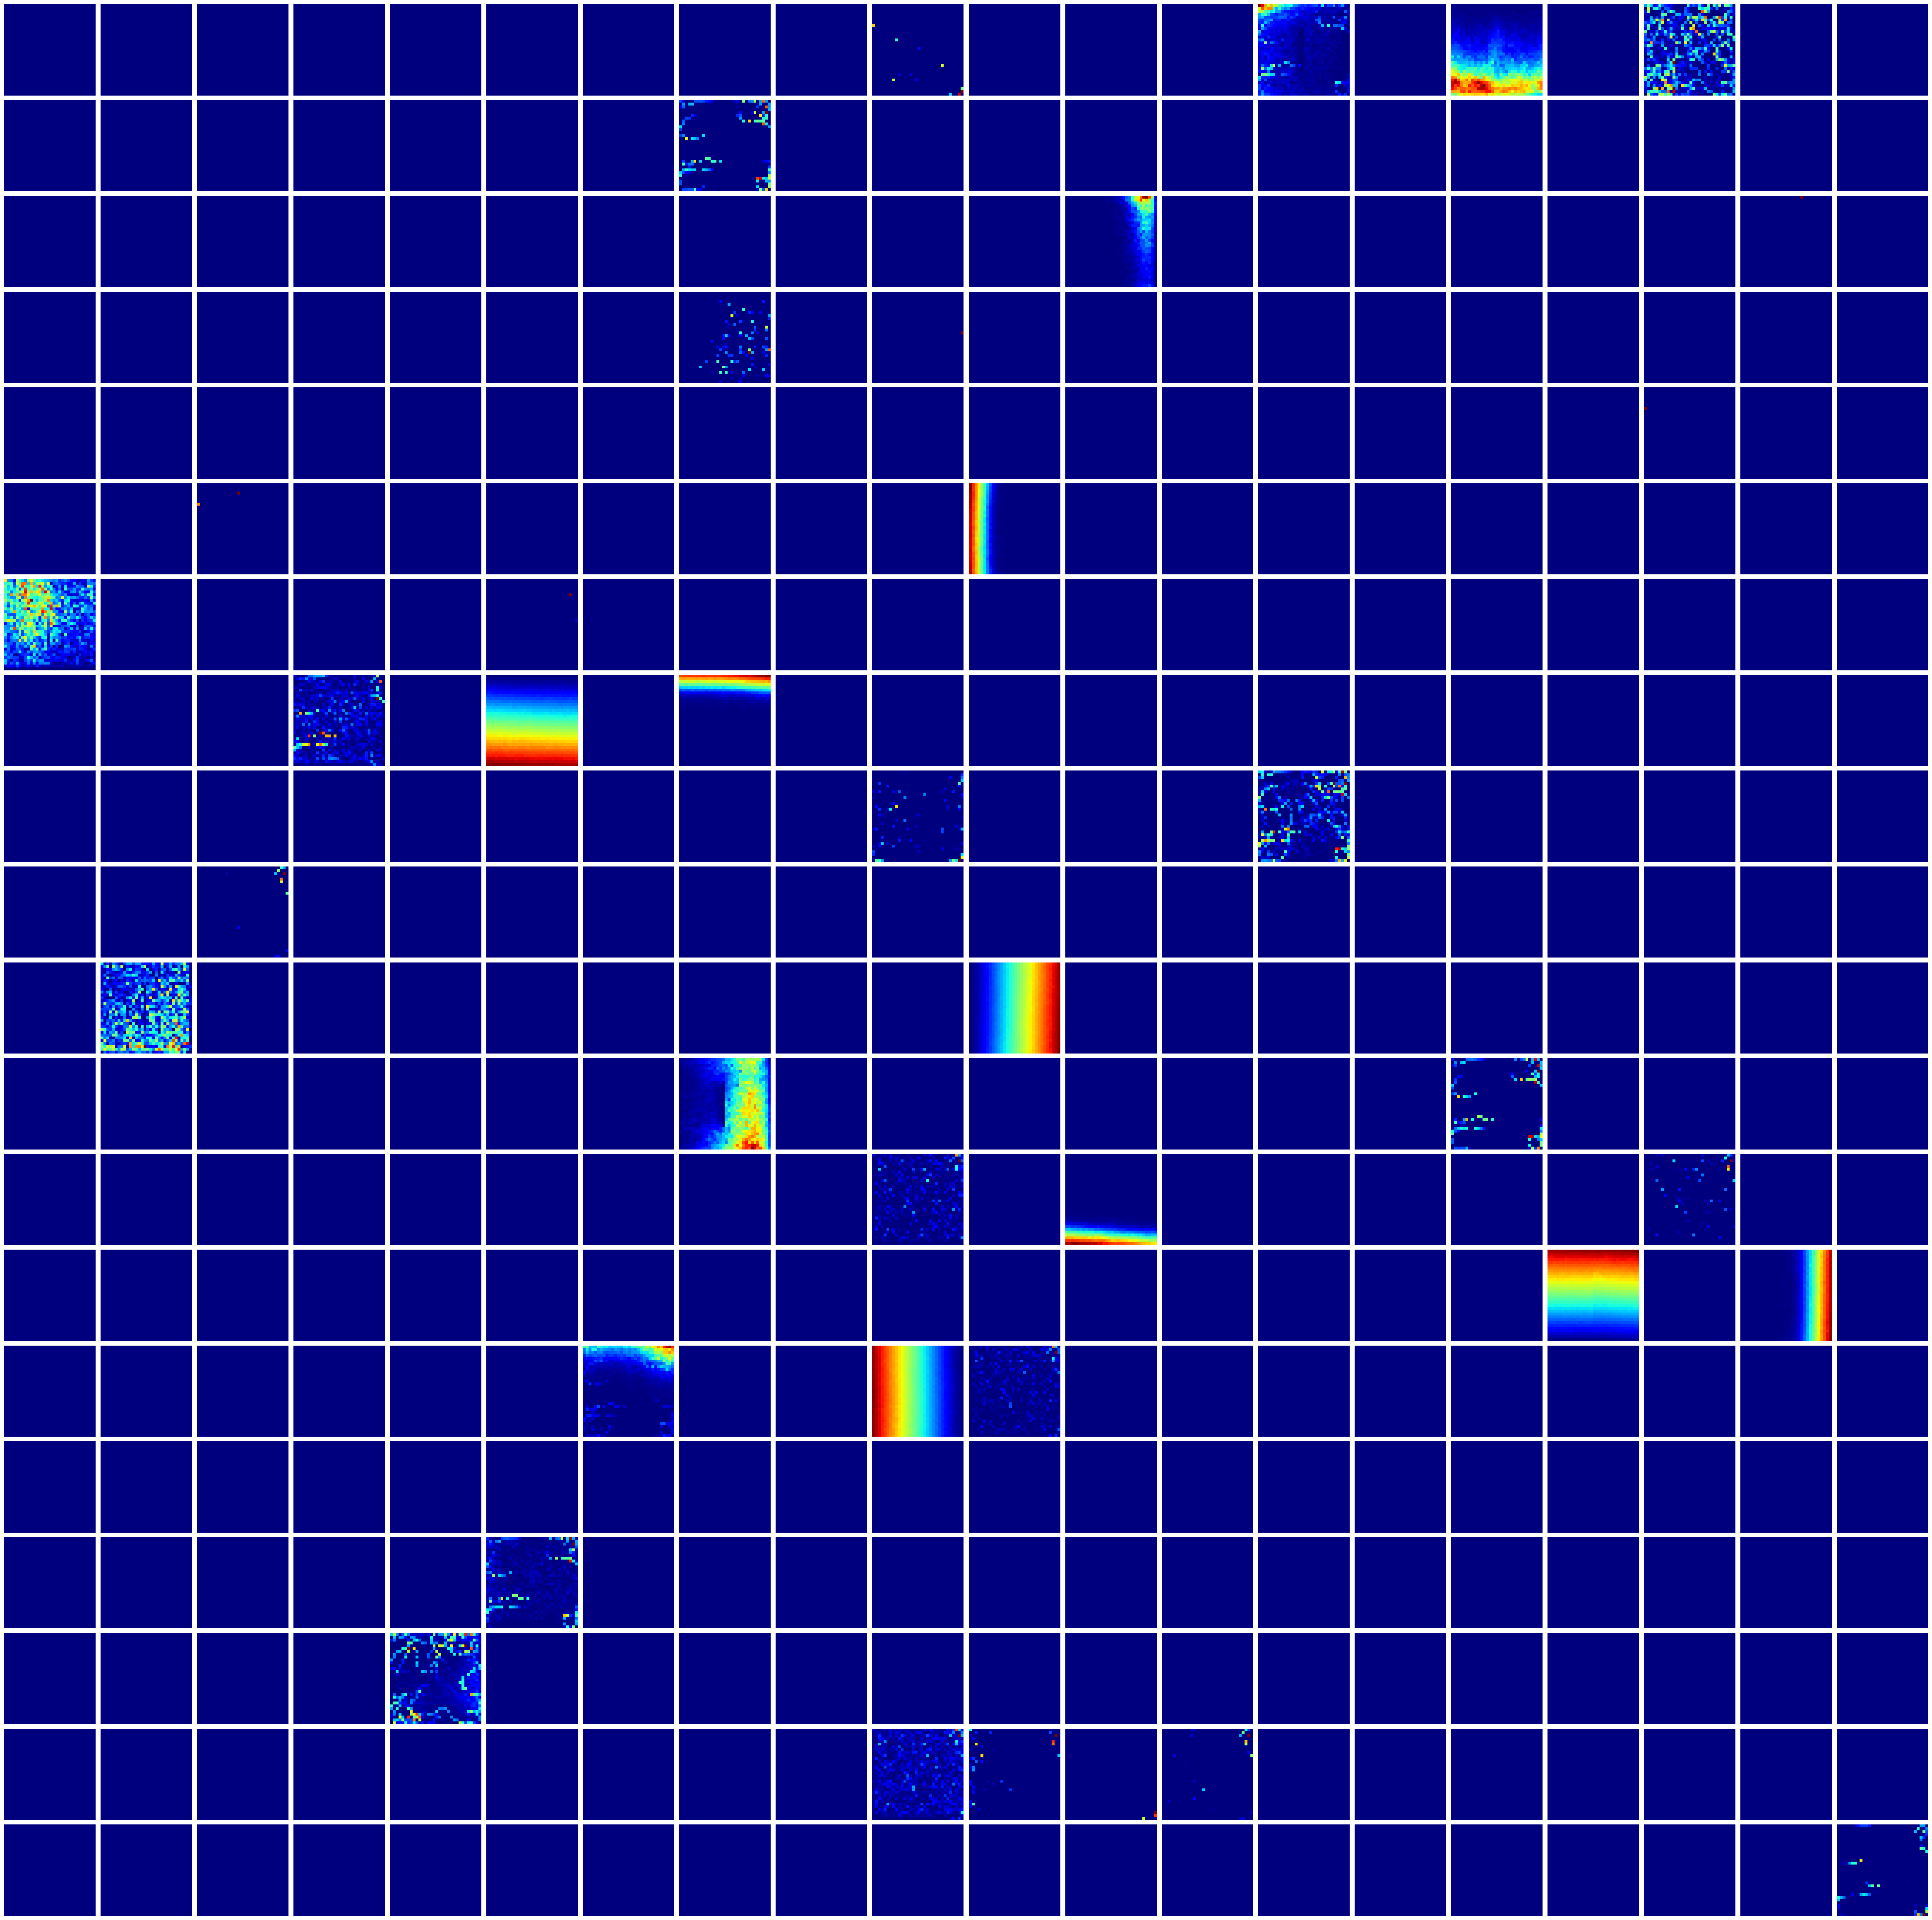

In [205]:
analysis_tools.plot_ensemble(g_ratemaps[0], n = 20);
plt.subplots_adjust(hspace = 0.05, wspace = 0.05)

In [15]:
mask, info = analysis_tools.spatial_information_selection(ps, r, [bins]*len(ps));
selected = centers[:,mask]

#selected = [centers[i, np.linalg.norm(centers[i], axis = -1) > 0] for i in range(len(centers))]
#selected = np.concatenate(selected, axis = 0)

/Users/m/Documents/jobb/phd/VariationalPlaceCells/notebooks/stats.py:93: RuntimeWarning: invalid value encountered in divide
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))
/Users/m/Documents/jobb/phd/VariationalPlaceCells/notebooks/stats.py:93: RuntimeWarning: divide by zero encountered in log2
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))
/Users/m/Documents/jobb/phd/VariationalPlaceCells/notebooks/stats.py:93: RuntimeWarning: invalid value encountered in multiply
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))


(500,) (10, 20000, 500) (10, 20000, 18) (1, 18, 32, 32)


(<Figure size 1200x1200 with 16 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >]], dtype=object))

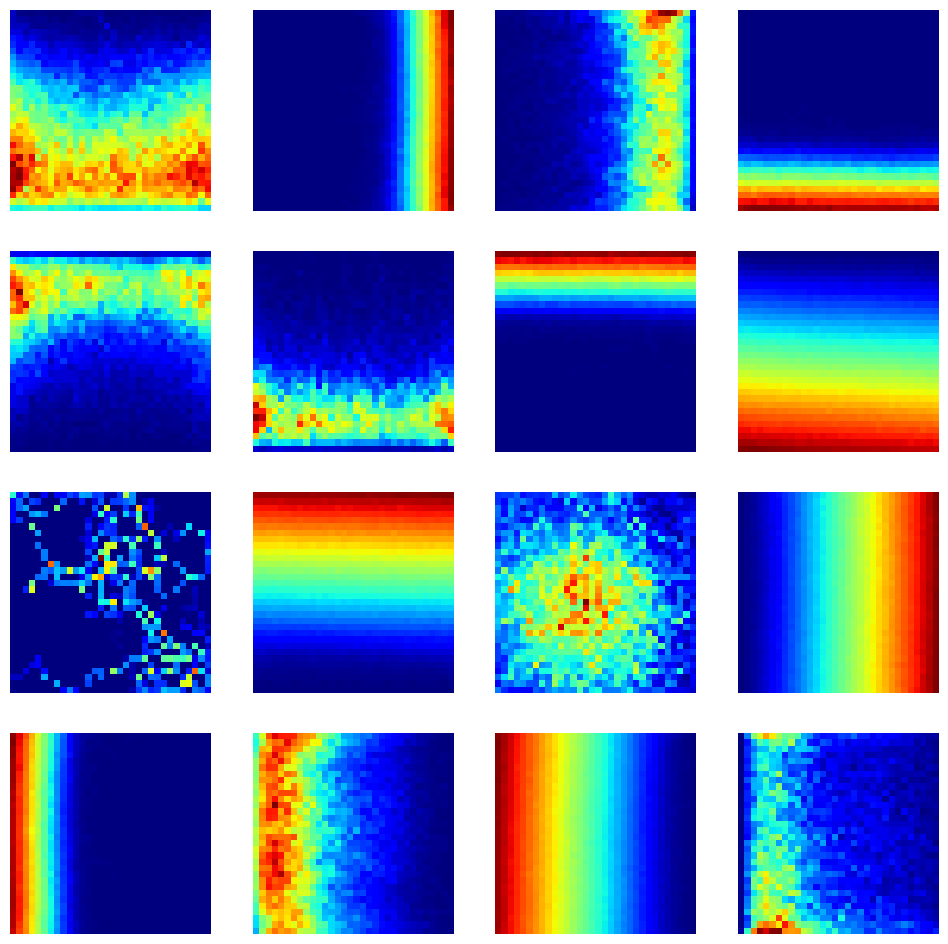

In [16]:
mask, info = analysis_tools.spatial_information_selection(gs, r, [bins]*len(gs), 0.01);
print(mask.shape, gs.shape,gs[:,:,mask].shape, g_ratemaps[:,mask].shape)
analysis_tools.plot_ensemble(g_ratemaps[0][mask], 4)

In [17]:
flat_g = np.reshape(g_ratemaps, (g_ratemaps.shape[1], -1))
node_ind = np.argmax(flat_g, axis = -1)

In [32]:
x = np.linspace(-1, 1, 32)
y = x
xx, yy = np.meshgrid(x,y)
rr = np.stack((xx.ravel(), yy.ravel()),axis = -1)


(500, 1024) (1024, 2)


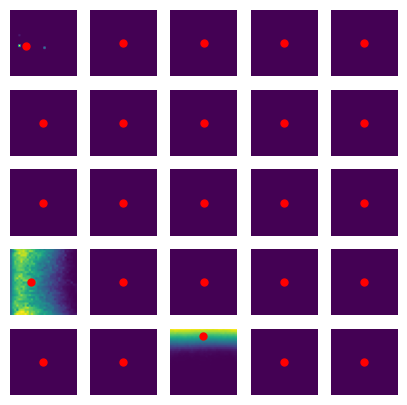

In [38]:
nn = 5
fig, ax = plt.subplots(nn, nn, figsize = (nn,nn))

print(flat_g.shape, rr.shape)

def decoding(r, g):
    z = g
    return np.nansum( r[None,:]*z[:,None], axis = -1)/(np.nansum(z + 1e-32, axis = -1, keepdims = True))
    
nodes = decoding(rr.T, flat_g)
gr =  nodes[mask]

for i in range(nn**2):
        ax[i//nn, i%nn].imshow(g_ratemaps[0,i], extent = [-1, 1, -1, 1], origin = "lower")
        ax[i//nn, i%nn].axis("off")
        ax[i//nn, i%nn].plot(*nodes[i].T, "ro", markersize = 5)

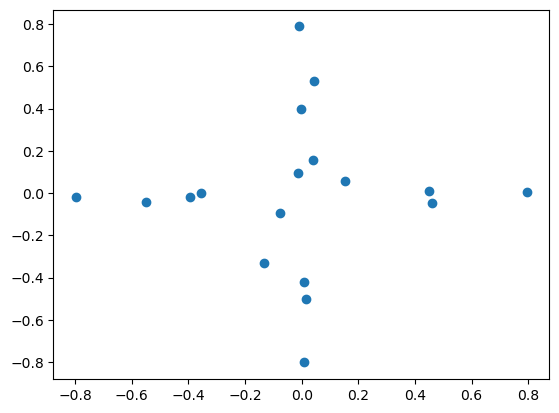

In [39]:
plt.plot(gr[:,0], gr[:,1], "o")

In [40]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

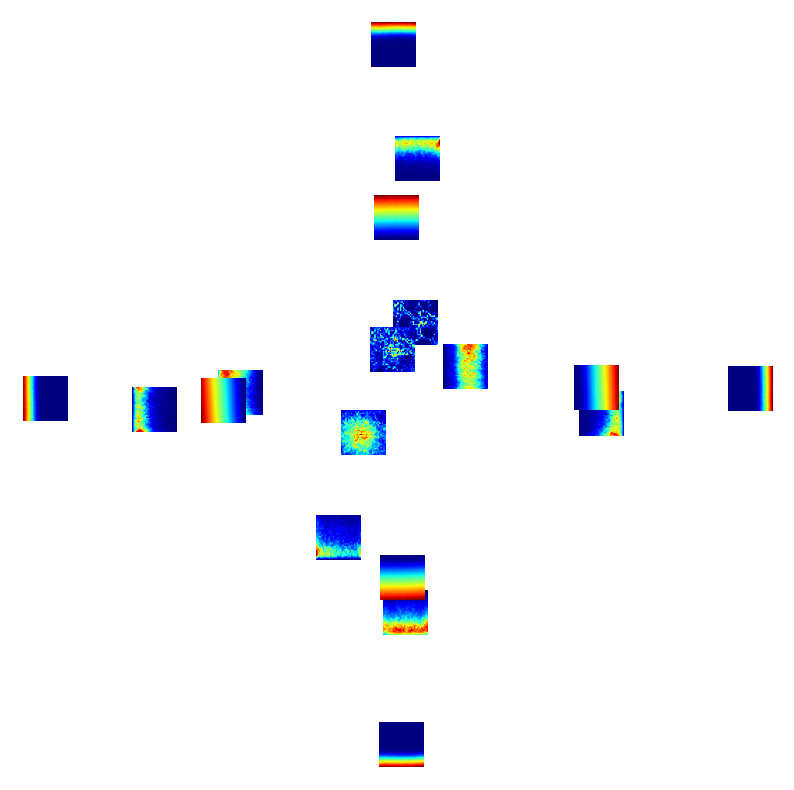

In [43]:
fig, ax = plt.subplots(1, figsize = (10,10))
for i in range(mask.sum()):
    x = gr[i, 0]
    y = gr[i, 1]
    im = OffsetImage(g_ratemaps[0,mask][i], cmap = "jet", origin = "lower")
    box = AnnotationBbox(im, (x, y), frameon = False) 

    ax.plot(x, y, "ok")
    ax.add_artist(box)

ax.axis("off")
plt.show()

In [44]:
w = model.rnn_layer.weight_hh_l0
w = w.detach().numpy()

In [24]:
import networkx as nx

In [186]:
selected = w[mask][:,mask]
selected.shape
colors = (selected - np.amin(selected))/(np.amax(selected) - np.amin(selected))

In [190]:
G = nx.DiGraph()

for i in range(len(selected)):
    G.add_node(i, pos = tuple(np.random.uniform(-1, 1, 2)))

for i in range(len(selected)):
    for j in range(len(selected)):
        if i!=j:
            G.add_edge(i,j, weight = selected[i,j], color = colors[i,j])
        

edges = G.edges()
cols = [G[u][v]['color'] for u,v in edges]
edge_labels = [G[u][v]["weight"] for u,v in edges]

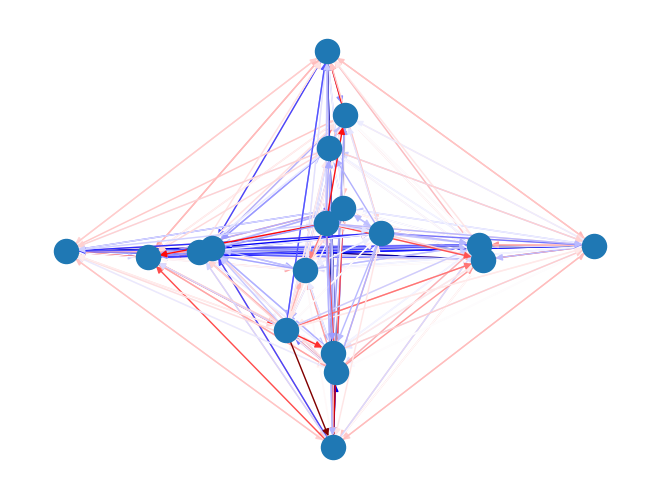

In [191]:
cmap = matplotlib.cm.get_cmap('seismic')

nx.draw(G, pos = gr, edge_color= cols, edge_cmap = cmap)

In [189]:
plt.plot(.ravel(), ".")

SyntaxError: invalid syntax (2264177952.py, line 1)